<a href="https://colab.research.google.com/github/ProfAI/tf00/blob/master/5%20-%20Reti%20Neurali%20Convoluzionali/convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ConvNet: Reti Neurali Convoluzionali
Le Reti Neurali Convoluzionali (ConvNet - Convolutional Neural Networks) sono una classe di Reti Neurali molto utilizzate in ambito Computer Vision. A differenza delle Vanilla Neural Netwoks che ragionano pixel per pixel, le ConvNet ragionano su intere porzioni delle immagini.
<br>
In questo notebook addestreremo una ConvNet per riconoscere casi di malaria in immagini di campioni di sangue.

## Importiamo i moduli

In [4]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout

from tensorflow.keras.layers import MaxPooling2D

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

## Prepariamo i Dati
Scarichiamo il dataset con le immagini utilizzando tensorflow-dataset.

In [5]:
dataset = tfds.load('malaria', split='train', shuffle_files=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete5V7B3J/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


Le immagini sono parecchie e la RAM di Colab, o del nostro PC, potrebbe non essere sufficiente, limitiamo il numero di campioni da utilizzare. Nel caso in cui avessi un PC con una buona GPU e tanta RAM, sentiti libero di aumentare il numero di capioni utilizzando la costante NUM_SAMPLES.

In [6]:
NUM_SAMPLES = 10000 # Numero di campioni per addestramento e test
IMG_SIZE = (150, 150) # dimensione di ogni immagine

Ridefiniamo la funzione load_data, ridimensionando al suo interno le immagini e convertendole in bianco e nero, per farlo ci serviremo di OpenCV.

In [7]:
def load_data(dataset, num_samples=None):
  images = []
  labels = []

  for i, example in enumerate(tfds.as_numpy(dataset)):

    if(num_samples!=None and i>=num_samples):
      break

    img = example["image"]
    img = cv2.resize(img, IMG_SIZE) # ridimensioniamo l'immagine
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convertiamo in bianco e nero
    images.append(img)
    labels.append(example["label"])

  images = np.array(images)
  labels = np.array(labels)

  return images, labels

images, labels = load_data(dataset, num_samples=NUM_SAMPLES)
num_classes = np.unique(labels).shape[0]

Stampiamo la prima immagine del dataset utilizzando matplotlib insieme al relativo target.

1


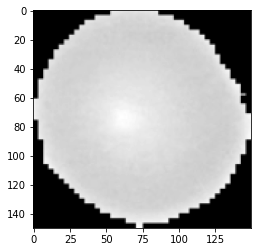

In [11]:
plt.imshow(images[0], cmap="gray")
print(labels[0])

0


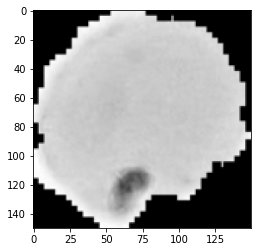

In [14]:
plt.imshow(images[2], cmap="gray")
print(labels[2])

Si tratta di un problema di classificazione binaria e le possibili classi per il target sono 2:

 - **0**: classe negativa, cellula infetta.
 - **1**: classe positiva, cellula sana.


 Come sempre, normalizziamo le immagini dividendo per 255

In [9]:
X = images/255

L'input di uno strato convoluzionale di tf.keras deve avere questa dimensione: *(NUM_SAMPLES, WIDTH, HEIGHT, NUM_CHANNELS)*, dove:

 - **NUM_SAMPES** è il numero di osservazioni (immagini in questo caso) che abbiamo.
 - **WIDTH e HEIGHT** sono rispettivamente larghezza e altezza di ogni immagine.
 - **NUM_CHANNELS** sono il numero di canali dell'immagine, 1 per immagini in bianco e nero, 3 per immagini in RGB.


 Possiamo ridimensionare il dataset per dargli questa forma utilizzando il metodo reshape di numpy.

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

Ora possiamo dividere il dataset in Train Set e Test Set

In [10]:
y = labels # lo faccio solo perché sono pignolo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## La nostra prima ConvNet
Per aggiungere degli strati convoluzionali alla rete neurale, possiamo utilizzare la classe *Conv2D*, questa richiede alcuni parametri:
 - **filters**: il numero di filtri che verranno ottimizzati durante la fase di addestramento.
 - **kernel_size**: la dimensione di ogni filtro, un valore di 2 indica che verranno utilizzati filtri di dimensione 2x2.
 - **padding**: il tipo di padding da utilizzare, i possibili valori sono:
 - - **same**: la dimensione della matrice di output sarà pari a quella di input.
 - - **valid**: non viene utilizzato nessun padding.

In [15]:
model = tf.keras.models.Sequential()

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 8)       40        
_________________________________________________________________
flatten_3 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 180001    
Total params: 180,041
Trainable params: 180,041
Non-trainable params: 0
_________________________________________________________________


Il modello che stiamo andando ad addestrare ha 180.041 parametri, configuriamolo e avviamo l'addestramento.

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, batch_size=512)

Epoch 1/10
16/16 [==============================] - 2s 127ms/step - loss: 2.6902 - accuracy: 0.4983
Epoch 2/10
16/16 [==============================] - 2s 111ms/step - loss: 0.8889 - accuracy: 0.5310
Epoch 3/10
16/16 [==============================] - 2s 110ms/step - loss: 0.6862 - accuracy: 0.5717
Epoch 4/10
16/16 [==============================] - 2s 109ms/step - loss: 0.6547 - accuracy: 0.6059
Epoch 5/10
16/16 [==============================] - 2s 109ms/step - loss: 0.6398 - accuracy: 0.6280
Epoch 6/10
16/16 [==============================] - 2s 111ms/step - loss: 0.6154 - accuracy: 0.6736
Epoch 7/10
16/16 [==============================] - 2s 110ms/step - loss: 0.5755 - accuracy: 0.7084
Epoch 8/10
16/16 [==============================] - 2s 109ms/step - loss: 0.5624 - accuracy: 0.7044
Epoch 9/10
16/16 [==============================] - 2s 111ms/step - loss: 0.5378 - accuracy: 0.7344
Epoch 10/10
16/16 [==============================] - 2s 110ms/step - loss: 0.5112 - accuracy: 0.7625

In [ ]:
metrics_train = model.evaluate(X_train, y_train, verbose=0)
metrics_test = model.evaluate(X_test, y_test, verbose=0)
print("Train Set: Accuracy=%.2f, Log Loss=%.4f" % (metrics_train[1], metrics_train[0]))
print("Test Set: Accuracy=%.2f, Log Loss=%.4f" % (metrics_test[1], metrics_test[0]))

Train Set: Accuracy=0.78, Log Loss=0.4905
Test Set: Accuracy=0.68, Log Loss=0.5866


Il risultato finale non è buonissimo e mostra un'accenno di overfitting, possiamo fare di meglio.

## MaxPooling
Solitamente una ConvNet presenta più di un'unico strato convoluzionale.

In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Ma un problema di questo approccio è che il numero di parametri da ottimizzare cresce a dismisura, rendendo la rete pesante da addestrare e decisamente incline all'overfitting.

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      4128      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 720000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               92160128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In questo caso ne abbiamo oltre 92 milioni, davvero tanti per il problema che stiamo affrontando. Una tecnica che possiamo sfruttare per ridurre il numero di parametri è il MaxPooling, che riduce la dimensione delle matrici tenendo soltanto il valore maggiore, all'interno di una finestra di dimensione definita (parametro *pool_size*).

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=3, strides=3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=3))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

Utilizzando il MaxPooling abbiamo ridotto il numero di parametri da ottimizzare a poco più di un milione, davvero un guadagno notevole. Compiliamo il modello e avviamo l'addestramento.

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30, batch_size=512)

Epoch 1/30
16/16 [==============================] - 5s 284ms/step - loss: 0.6926 - accuracy: 0.5366
Epoch 2/30
16/16 [==============================] - 4s 274ms/step - loss: 0.6676 - accuracy: 0.5981
Epoch 3/30
16/16 [==============================] - 4s 276ms/step - loss: 0.6489 - accuracy: 0.6246
Epoch 4/30
16/16 [==============================] - 4s 276ms/step - loss: 0.6279 - accuracy: 0.6425
Epoch 5/30
16/16 [==============================] - 4s 276ms/step - loss: 0.6051 - accuracy: 0.6691
Epoch 6/30
16/16 [==============================] - 4s 278ms/step - loss: 0.5924 - accuracy: 0.6808
Epoch 7/30
16/16 [==============================] - 4s 276ms/step - loss: 0.5802 - accuracy: 0.6934
Epoch 8/30
16/16 [==============================] - 4s 275ms/step - loss: 0.5666 - accuracy: 0.7156
Epoch 9/30
16/16 [==============================] - 4s 275ms/step - loss: 0.5556 - accuracy: 0.7120
Epoch 10/30
16/16 [==============================] - 4s 276ms/step - loss: 0.5409 - accuracy: 0.7295

In [ ]:
metrics_train = model.evaluate(X_train, y_train, verbose=0)
metrics_test = model.evaluate(X_test, y_test, verbose=0)
print("Train Set: Accuracy=%.2f, Log Loss=%.4f" % (metrics_train[1], metrics_train[0]))
print("Test Set: Accuracy=%.2f, Log Loss=%.4f" % (metrics_test[1], metrics_test[0]))

Train Set: Accuracy=0.89, Log Loss=0.3315
Test Set: Accuracy=0.85, Log Loss=0.4076


Adesso le metrice sono decisamente migliori.